# Lithium prescribing trends in England. 

## **Background and Rationale**
For over 60 years lithium has been the gold standard for the treatment and prevention of relapse in bipolar disorder.  In recent years, published literature has confirmed the superiority of lithium in this field, including two meta-analysis of RCTs (Severus et al. 2014, Miura et al. 2014) and one of observational studies (Kessing et al 2018).  Yet in various countries, authors have described a decline in lithium use (Karanti et al. 2016), including in the UK (Hayes et al. 2011, Lyall et al. 2019) 

We wish to describe long term lithium prescribing trends in England.  Previous authors have reported regional variations in lithium use across the country (POMH Lithium report, 2008). We would like to explore these national variations in use, to further understand trends in lithium prescribing in the UK. 

## **Proposed project**
### Title:  
Lithium prescribing trends
### Description:  
* Total number of items of lithium carbonate and lithium citrate dispensed per year from 1995 to 2018
* Total number of non-GP v GP items of lithium carbonate and lithium citrate dispensed per year
* Number of items of lithium carbonate per 1000 patient population for each CCG
* Number of items of lithium citrate per 1000 patient population for each CCG
* Number of items of non-GP v GP prescriptions for lithium carbonate for each region
* Number of items of non-GP v GP prescriptions for lithium citrate for each region



In [2]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from matplotlib.dates import DateFormatter
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import matplotlib.gridspec as gridspec

In [3]:
sql = """
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
rx.practice,
rx.pct,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(IF(rx.bnf_code LIKE "0402030K0%", items,0)) AS carbonate,
sum(IF(rx.bnf_code LIKE "0402030P0%", items,0)) AS citrate,
sum(items) AS total_lithium,
sum(actual_cost) AS total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
JOIN
hscic.practices AS prac
ON
rx.practice = prac.code 
JOIN
  hscic.ccgs AS ccgs
ON
rx.pct=ccgs.code
WHERE
  prac.setting = 4
  AND (bnf_code LIKE "0402030K0%" OR ##carbonate
  bnf_code LIKE "0402030P0%") ##citrate
  AND
ccgs.org_type='CCG'
GROUP BY
rx.month,
rx.practice,
rx.pct,
chemical_code,
chemical
ORDER BY
month"""

df_lithium = bq.cached_read(sql, csv_path='lithium.csv')

In [4]:
df_lithium['month'] = df_lithium['month'].astype('datetime64[ns]')
df_lithium.head()

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01,H81019,09Y,0402030K0,Lithium Carbonate,7,0,7,27.23
1,2010-08-01,G81029,09F,0402030K0,Lithium Carbonate,25,0,25,46.04
2,2010-08-01,B81077,03H,0402030K0,Lithium Carbonate,5,0,5,7.97
3,2010-08-01,F85063,08D,0402030K0,Lithium Carbonate,12,0,12,40.90
4,2010-08-01,H85053,08T,0402030K0,Lithium Carbonate,8,0,8,2.73


In [5]:
df_lithium["chemical"].unique()#shows me the unique values within the chemical column

array(['Lithium Carbonate', 'Lithium Citrate'], dtype=object)

In [6]:
df_lithium.nunique()#counts the number of unique items in each column.  

month               110
practice           8022
pct                 191
chemical_code         2
chemical              2
carbonate           136
citrate              35
total_lithium       135
total_cost       190699
dtype: int64

In [7]:
df_carbonate = df_lithium.loc[df_lithium["chemical"] == "Lithium Carbonate"]
df_carbonate.head()#shows me the data for Lithium Carbonate

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01,H81019,09Y,0402030K0,Lithium Carbonate,7,0,7,27.23
1,2010-08-01,G81029,09F,0402030K0,Lithium Carbonate,25,0,25,46.04
2,2010-08-01,B81077,03H,0402030K0,Lithium Carbonate,5,0,5,7.97
3,2010-08-01,F85063,08D,0402030K0,Lithium Carbonate,12,0,12,40.90
4,2010-08-01,H85053,08T,0402030K0,Lithium Carbonate,8,0,8,2.73


In [8]:
df_carbonate.nunique()

month               110
practice           8019
pct                 191
chemical_code         1
chemical              1
carbonate           135
citrate               1
total_lithium       135
total_cost       186539
dtype: int64

In [9]:
df_carbonate.describe()

,carbonate,citrate,total_lithium,total_cost
count,750370.000000,750370.0,750370.000000,750370.000000
mean,10.508155,0.0,10.508155,17.857388
std,10.033071,0.0,10.033071,25.709286
min,1.000000,0.0,1.000000,0.060000
25%,4.000000,0.0,4.000000,5.310000
50%,8.000000,0.0,8.000000,10.990000
75%,14.000000,0.0,14.000000,20.480000
max,162.000000,0.0,162.000000,1734.052160


In [10]:
df_citrate = df_lithium.loc[df_lithium["chemical"] == "Lithium Citrate"]
df_citrate.head()#shows me the data for Lithium Citrate

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
79,2010-08-01,C84605,04N,0402030P0,Lithium Citrate,0,1,1,5.36
90,2010-08-01,P81103,01E,0402030P0,Lithium Citrate,0,2,2,26.39
100,2010-08-01,G83001,08A,0402030P0,Lithium Citrate,0,1,1,42.66
111,2010-08-01,C88079,03N,0402030P0,Lithium Citrate,0,1,1,10.36
127,2010-08-01,N81046,02F,0402030P0,Lithium Citrate,0,2,2,44.80


In [11]:
df_citrate.nunique()

month             110
practice         2881
pct               191
chemical_code       1
chemical            1
carbonate           1
citrate            34
total_lithium      34
total_cost       7713
dtype: int64

In [12]:
df_citrate.describe()

,carbonate,citrate,total_lithium,total_cost
count,55641.0,55641.000000,55641.000000,55641.000000
mean,0.0,1.441132,1.441132,20.189354
std,0.0,1.292081,1.292081,16.424283
min,0.0,1.000000,1.000000,0.176270
25%,0.0,1.000000,1.000000,10.380000
50%,0.0,1.000000,1.000000,16.101890
75%,0.0,2.000000,2.000000,24.993740
max,0.0,43.000000,43.000000,660.744000


In [13]:
ccg_lithium_totalcount = df_lithium.groupby(["pct", "month"], as_index=False).sum()
ccg_lithium_totalcount.head()#shows me the data grouped by PCT, therefore representing CCGs

,pct,month,carbonate,citrate,total_lithium,total_cost
0,00C,2010-08-01,329,4,333,285.47
1,00C,2010-09-01,354,1,355,257.35
2,00C,2010-10-01,315,5,320,282.27
3,00C,2010-11-01,302,1,303,238.85
4,00C,2010-12-01,325,4,329,275.83


In [14]:
ccg_lithium_totalcount.describe()

,carbonate,citrate,total_lithium,total_cost
count,21010.000000,21010.000000,21010.000000,21010.000000
mean,375.297668,3.816564,379.114231,691.242443
std,300.596623,4.707237,304.017283,600.048727
min,27.000000,0.000000,27.000000,49.340000
25%,201.000000,1.000000,203.000000,337.285000
50%,290.000000,2.000000,293.000000,509.399650
75%,446.000000,5.000000,450.000000,822.431118
max,2147.000000,54.000000,2167.000000,5321.818920


### Display total no. of items dispensed per year

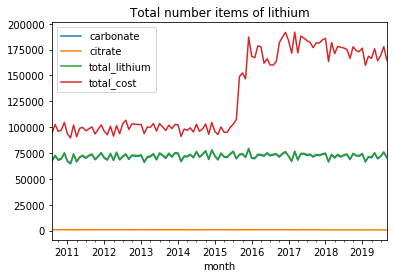

In [15]:
plot1 = df_lithium.groupby("month").sum().plot(kind='line', title="Total number items of lithium")

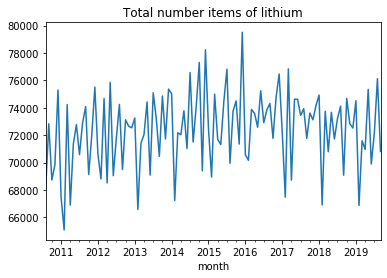

In [16]:
plot2 = df_lithium.groupby("month")['total_lithium'].sum().plot(kind='line', title="Total number items of lithium")

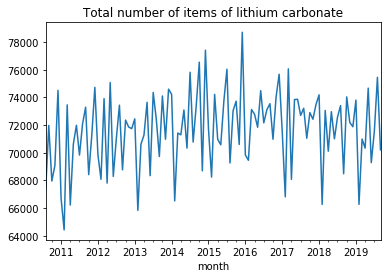

In [17]:
plot3 = df_lithium.groupby("month")['carbonate'].sum().plot(kind='line', title='Total number of items of lithium carbonate')

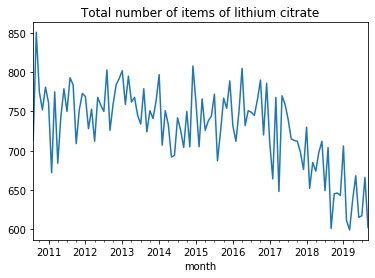

In [18]:
plot4 = df_lithium.groupby("month")["citrate"].sum().plot(kind='line', title='Total number of items of lithium citrate')

### Explore costs of individual brands of lithium over time (2014 to 2019) to see what caused increased costs in 2016

In [20]:
sql = """
WITH
bnf_tab AS (
SELECT
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(IF(rx.bnf_code LIKE "0402030%", items,0)) AS lithium,
sum(items) AS total_lithium,
sum(actual_cost) AS total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)

WHERE
  prac.setting = 4
  AND (bnf_code LIKE "0402030%") OR ##lithium

GROUP BY
rx.month,
chemical_code,
chemical
ORDER BY
month"""

df_lithium_brands = bq.cached_read(sql, csv_path='lithium.csv')

GenericGBQException: Reason: 400 Syntax error: Unexpected keyword GROUP at [26:1]

(job ID: 2a8209b7-bc18-4fac-a06f-84fa9d8e5fe8)

               -----Query Job SQL Follows-----                

    |    .    |    .    |    .    |    .    |    .    |
   1:
   2:WITH
   3:bnf_tab AS (
   4:SELECT
   5:chemical_code
   6:FROM
   7:ebmdatalab.hscic.bnf )
   8:SELECT
   9:rx.month,
  10:SUBSTR(rx.bnf_code,1,9) AS chemical_code,
  11:chemical,
  12:sum(IF(rx.bnf_code LIKE "0402030%", items,0)) AS lithium,
  13:sum(items) AS total_lithium,
  14:sum(actual_cost) AS total_cost
  15:FROM
  16:hscic.normalised_prescribing_standard AS rx
  17:LEFT JOIN
  18:bnf_tab
  19:ON
  20:chemical_code =SUBSTR(rx.bnf_code,1,9)
  21:
  22:WHERE
  23:  prac.setting = 4
  24:  AND (bnf_code LIKE "0402030%") OR ##lithium
  25:
  26:GROUP BY
  27:rx.month,
  28:chemical_code,
  29:chemical
  30:ORDER BY
  31:month
    |    .    |    .    |    .    |    .    |    .    |

In [20]:
##get list size info
sql2 = """
SELECT month, 
pct_id AS pct,
AVG(total_list_size) AS list_size
FROM ebmdatalab.hscic.practice_statistics
group by 
month, pct
order by
month, pct,
list_size
"""
df_list = bq.cached_read(sql2, csv_path='df_list.csv')
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(5)

,month,pct,list_size
0,2014-10-01,NaN,0.000000
1,2014-10-01,00C,7616.000000
2,2014-10-01,00D,5662.509804
3,2014-10-01,00F,6102.176471
4,2014-10-01,00G,8058.750000


In [21]:
ccg_lithium_count = df_lithium.groupby(["month", "pct"])["total_lithium"].sum().reset_index()
ccg_lithium_count.head()

,month,pct,total_lithium
0,2010-08-01,00C,333
1,2010-08-01,00D,496
2,2010-08-01,00J,456
3,2010-08-01,00K,295
4,2010-08-01,00L,595


In [22]:
#merge dataframes to show items per 1000

df_lithium_per1000 = pd.merge(ccg_lithium_count, df_list, on=['month', 'pct'])
df_lithium_per1000['items_per_1000'] = round(1000* (df_lithium_per1000['total_lithium']/df_lithium_per1000['list_size']),0)
df_lithium_per1000.head()

,month,pct,total_lithium,list_size,items_per_1000
0,2014-10-01,00C,381,7616.000000,50.0
1,2014-10-01,00D,639,5662.509804,113.0
2,2014-10-01,00J,607,6094.536585,100.0
3,2014-10-01,00K,310,6354.130435,49.0
4,2014-10-01,00L,728,6852.085106,106.0


In [23]:
df_lithium_per1000["month"] = pd.to_datetime(df_lithium_per1000['month']).dt.date

In [24]:
df_lithium_per1000.describe()

,total_lithium,list_size,items_per_1000
count,11064.000000,11064.000000,11064.000000
mean,351.204266,7953.832679,45.906905
std,243.674721,1962.515474,32.186258
min,40.000000,3682.023810,3.000000
25%,200.000000,6548.007177,27.000000
50%,285.000000,7733.210884,39.000000
75%,435.000000,9241.958333,56.000000
max,2007.000000,16296.600000,316.000000


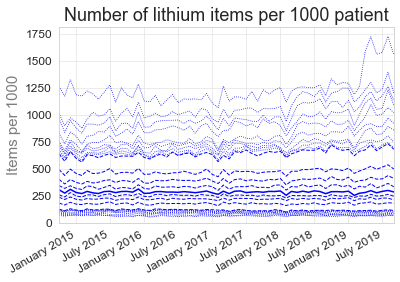

In [25]:
#create sample deciles

charts.deciles_chart(
        df_lithium_per1000,
        period_column='month',
        column='total_lithium',
        title="Number of lithium items per 1000 patient",
        ylabel='Items per 1000',
        show_outer_percentiles=True,
        show_legend=False,
)

plt.show()

### Describe lithium items prescribed by non-GP facilities in UK

In [26]:
sql3 = """
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
rx.practice,
prac.setting,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(IF(rx.bnf_code LIKE "0402030K0%", items,0)) AS carbonate,
sum(IF(rx.bnf_code LIKE "0402030P0%", items,0)) AS citrate,
sum(items) AS total_lithium,
sum(actual_cost) AS total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
JOIN
hscic.practices AS prac
ON
rx.practice = prac.code 

WHERE
  prac.setting !=4
  AND (bnf_code LIKE "0402030K0%" OR ##carbonate
  bnf_code LIKE "0402030P0%") ##citrate
  
GROUP BY
rx.month,
rx.practice,
rx.pct,
prac.setting,
chemical_code,
chemical
ORDER BY
month"""

df_nonGPlithium = bq.cached_read(sql3, csv_path='nonGPlithium.csv')

Downloading: 100%|██████████| 8684/8684 [00:01<00:00, 7789.41rows/s]


In [27]:
df_nonGPlithium['month'] = df_nonGPlithium['month'].astype('datetime64[ns]')
df_nonGPlithium

,month,practice,setting,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01,Y00030,2,0402030K0,Lithium Carbonate,1,0,1,0.43000
1,2010-08-01,Y02247,9,0402030K0,Lithium Carbonate,2,0,2,0.90000
2,2010-08-01,E87670,0,0402030K0,Lithium Carbonate,2,0,2,2.43000
3,2010-08-01,Y00049,0,0402030K0,Lithium Carbonate,7,0,7,4.32000
4,2010-08-01,Y00751,2,0402030K0,Lithium Carbonate,2,0,2,0.42000
...,...,...,...,...,...,...,...,...,...
8679,2019-09-01,Y02081,2,0402030K0,Lithium Carbonate,2,0,2,0.35479
8680,2019-09-01,Y04058,9,0402030K0,Lithium Carbonate,2,0,2,4.40299
8681,2019-09-01,Y03557,9,0402030K0,Lithium Carbonate,1,0,1,0.63235
8682,2019-09-01,Y05586,10,0402030K0,Lithium Carbonate,2,0,2,23.89192


In [28]:
df_nonGPlithium.groupby('month').sum()

,setting,carbonate,citrate,total_lithium,total_cost
month,,,,,
2010-08-01,232,230,2,232,280.83000
2010-09-01,264,274,4,278,401.41000
2010-10-01,195,239,2,241,315.50000
2010-11-01,203,232,2,234,332.89000
2010-12-01,223,250,3,253,370.37000
...,...,...,...,...,...
2019-05-01,532,189,3,192,354.18158
2019-06-01,442,145,3,148,270.24376
2019-07-01,469,149,0,149,251.67529


In [29]:
headers = [
    'code','name','postcode','status_code','ccg','setting']
nonGPbreakdown = pd.read_csv("lithium.csv", names=headers, usecols=[0,1,9,12,23,25])
nonGPbreakdown.head()

,code,name,postcode,status_code,ccg,setting
0,month,practice,NaN,NaN,NaN,NaN
1,2010-08-01 00:00:00+00:00,H81019,NaN,NaN,NaN,NaN
2,2010-08-01 00:00:00+00:00,G81029,NaN,NaN,NaN,NaN
3,2010-08-01 00:00:00+00:00,B81077,NaN,NaN,NaN,NaN
4,2010-08-01 00:00:00+00:00,F85063,NaN,NaN,NaN,NaN


In [1]:
plot5 = df_nonGPlithium.groupby("month")["total_lithium"].sum().plot(kind='line', title="Total number items of lithium by nonGP orgs")

NameError: name 'df_nonGPlithium' is not defined